#TCIA Image Data Retrieval and Processing
This notebook focuses on downloading and processing medical image data from The Cancer Imaging Archive (TCIA), a publicly available repository of medical imaging data. The notebook retrieves image series, downloads them, and handles different file types such as CSV, Excel, and JSON, enabling further analysis and integration into research projects.


In [47]:
!pip install pydicom
!pip install requests

In [48]:
import requests
import os
import json
import pandas as pd
import zipfile

In [49]:
#Retrieving Series from the LIDC-IDRI Collection via TCIA API
BASE_URL = "https://services.cancerimagingarchive.net/services/v3/"
COLLECTION = "LIDC-IDRI"

# Directory to save downloaded files
download_dir = "/content/LIDC_IDRI_Images"
os.makedirs(download_dir, exist_ok=True)


In [50]:
#Retrieving Series from the LIDC-IDRI Collection using TCIA API
def get_series(collection):
    url = f"{BASE_URL}TCIA/query/getSeries?Collection={collection}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to fetch series list.")
        return None

series_list = get_series(COLLECTION)
print(f"Found {len(series_list)} series in the collection.")


Found 15116 series in the collection.


In [51]:
#Downloading a Series from TCIA by SeriesInstanceUID
def download_series(series_instance_uid, save_dir):
    url = f"{BASE_URL}TCIA/query/getImage?SeriesInstanceUID={series_instance_uid}"
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        filepath = os.path.join(save_dir, f"{series_instance_uid}.zip")
        with open(filepath, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Downloaded: {filepath}")
    else:
        print(f"Failed to download series: {series_instance_uid}")

# Download the first series as an example
if series_list:
    first_series_uid = series_list[0]["SeriesInstanceUID"]
    download_series(first_series_uid, download_dir)


Downloaded: /content/LIDC_IDRI_Images/1.3.6.1.4.1.14519.5.2.1.6279.6001.141365756818074696859567662357.zip


Extracted: 1.3.6.1.4.1.14519.5.2.1.6279.6001.141365756818074696859567662357.zip


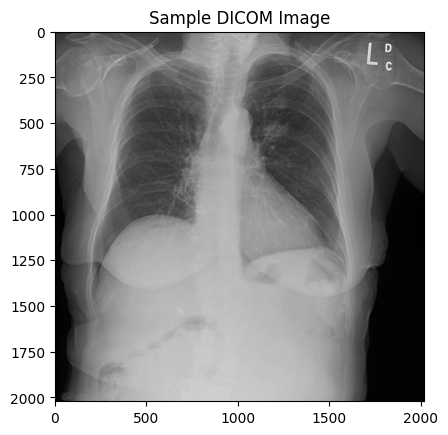

In [52]:
# Unzip the downloaded file
for file in os.listdir(download_dir):
    if file.endswith(".zip"):
        with zipfile.ZipFile(os.path.join(download_dir, file), 'r') as zip_ref:
            zip_ref.extractall(download_dir)
        print(f"Extracted: {file}")

# Load DICOM images
import pydicom
import matplotlib.pyplot as plt

dcm_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(download_dir) for f in filenames if f.endswith('.dcm')]

# Display the first DICOM image
if dcm_files:
    dicom_image = pydicom.dcmread(dcm_files[0])
    plt.imshow(dicom_image.pixel_array, cmap=plt.cm.gray)
    plt.title("Sample DICOM Image")
    plt.show()


In [53]:
from google.colab import drive
drive.mount('/content/drive')

# Save to Google Drive
drive_save_dir = '/content/drive/My Drive/LIDC_IDRI_Images'
os.makedirs(drive_save_dir, exist_ok=True)
!cp -r {download_dir}/* {drive_save_dir}/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: target 'Drive/LIDC_IDRI_Images/' is not a directory


In [54]:
#Downloading and Loading Files into DataFrame (CSV, Excel, JSON)
def download_and_load_file(url, save_path, file_type="csv"):

    import requests
    import pandas as pd

    try:
        # Download the file
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        with open(save_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {save_path}")

        # Load the file based on its type
        if file_type == "csv":
            df = pd.read_csv(save_path)
            print("CSV file successfully loaded into DataFrame.")
            return df
        elif file_type == "excel":
            df = pd.read_excel(save_path)
            print("Excel file successfully loaded into DataFrame.")
            return df
        elif file_type == "json":
            df = pd.read_json(save_path)
            print("JSON file successfully loaded into DataFrame.")
            return df
        else:
            print(f"Unsupported file type: {file_type}. Only 'csv', 'excel', and 'json' are supported.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Failed to download the file: {e}")
        return None
    except (pd.errors.EmptyDataError, ValueError) as e:
        print(f"Failed to load the file into a DataFrame: {e}")
        return None

In [55]:
#DICOM Metadata Digest
#This is information related to radiologists' assessments and data segments that contain information about the tumors.
url_csv = "https://www.cancerimagingarchive.net/wp-content/uploads/LIDC-IDRI_MetaData.csv"
save_path_csv = "/content/LIDC-IDRI_MetaData.csv"
metadata_df = download_and_load_file(url_csv, save_path_csv, file_type="csv")
print(metadata_df.head())


Downloaded: /content/LIDC-IDRI_MetaData.csv
CSV file successfully loaded into DataFrame.
       Subject ID                                          Study UID  \
0  LIDC-IDRI-1001  1.3.6.1.4.1.14519.5.2.1.6279.6001.281499745765...   
1  LIDC-IDRI-0778  1.3.6.1.4.1.14519.5.2.1.6279.6001.174809695196...   
2  LIDC-IDRI-0813  1.3.6.1.4.1.14519.5.2.1.6279.6001.139110171863...   
3  LIDC-IDRI-0710  1.3.6.1.4.1.14519.5.2.1.6279.6001.116146223752...   
4  LIDC-IDRI-0410  1.3.6.1.4.1.14519.5.2.1.6279.6001.818775038273...   

  Study Description             Study Date  \
0               NaN  2000-01-01 00:00:00.0   
1             CHEST  2000-01-01 00:00:00.0   
2               NaN  2000-01-01 00:00:00.0   
3             CHEST  2000-01-01 00:00:00.0   
4    CT LUNG SCREEN  2000-01-01 00:00:00.0   

                                           Series ID    Series Description  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...                   NaN   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.10033216

###Nodule count per patient
This is information about the number of tumors in each patient. This can be downloaded as a JSON or CSV file.

In [56]:
#Nodule count per patient
#This is information about the number of tumors in each patient. This can be downloaded as CSV file.
url_excel = "https://www.cancerimagingarchive.net/wp-content/uploads/lidc-idri-nodule-counts-6-23-2015.xlsx"  # Replace with actual URL
save_path_excel = "/content/nodule_count_per_patient.xlsx"
nodule_data_df = download_and_load_file(url_excel, save_path_excel, file_type="excel")
print(nodule_data_df.head())

Downloaded: /content/nodule_count_per_patient.xlsx
Excel file successfully loaded into DataFrame.
   TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
0  LIDC-IDRI-0001                          4                          1   
1  LIDC-IDRI-0002                         12                          1   
2  LIDC-IDRI-0003                          4                          4   
3  LIDC-IDRI-0004                          4                          1   
4  LIDC-IDRI-0005                          9                          3   

   Number of Nodules <3mm***  Unnamed: 4  \
0                          3         NaN   
1                         11         NaN   
2                          0         NaN   
3                          3         NaN   
4                          6         NaN   

                                          Unnamed: 5  
0                                                NaN  
1  *total number of lesions that received either ...  
2  **total number of 

In [57]:
#Patient Diagnoses
#This is information about the patients' medical diagnoses. Again, you may need to go through the API to locate the appropriate files.
url_excel = "https://www.cancerimagingarchive.net/wp-content/uploads/tcia-diagnosis-data-2012-04-20.xls"  # Replace with actual URL
save_path_excel = "/content/Patient_Diagnoses.xlsx"
patient_diagnoses_df = download_and_load_file(url_excel, save_path_excel, file_type="excel")
print(patient_diagnoses_df.head())

Downloaded: /content/Patient_Diagnoses.xlsx
Excel file successfully loaded into DataFrame.
  TCIA Patient ID  \
0  LIDC-IDRI-0068   
1  LIDC-IDRI-0071   
2  LIDC-IDRI-0072   
3  LIDC-IDRI-0088   
4  LIDC-IDRI-0090   

   Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n  \
0                                                  3                                                                                             
1                                                  3                                                                                             
2                                                  2                                                                                             
3                                                  3                                                                                             
4                                                  2